In [1]:
import numpy as np
import cvxpy as cp
import mosek
import matplotlib.pyplot as plt
import scipy.stats as stats
#import pymc3 as pm
import math
import matplotlib.dates as mdates

from scipy.optimize import minimize

from scipy.special import gamma
#from scipy.special import beta
from scipy.special import betainc

from scipy.integrate import quad
from scipy.stats import multivariate_normal
from scipy.stats import t
from scipy.stats import norm

import time

In [ ]:
##Load data
!pip install yfinance
import yfinance as yf
import pandas as pd

start_date = "2019-01-01"
end_date = "2021-08-01"

#Choose stocks
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'ADBE', 'NFLX', 'ADM', 'V', 'JNJ', 'COST', 'WMT', 'PG', 'MA', 'UNH', 'DIS', 'HD', 'INTC', 'PYPL', 'GS', 'IBM']



data = pd.DataFrame()

for ticker in tickers:
    print(f"Fetching data for {ticker}")
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    data[ticker] = stock_data['Close']

nu=1.5
#Daily return
daily_returns = data.pct_change().dropna()
daily_returns=daily_returns.values
#print(daily_returns.head())

# Daily loss
daily_losses = -daily_returns

#Dimension of the loss variable
d=daily_losses.shape[1]

[*********************100%***********************]  1 of 1 completed

Fetching data for AAPL
Fetching data for MSFT



[*********************100%***********************]  1 of 1 completed


Fetching data for GOOGL


[*********************100%***********************]  1 of 1 completed


Fetching data for AMZN


[*********************100%***********************]  1 of 1 completed


Fetching data for ADBE


[*********************100%***********************]  1 of 1 completed


Fetching data for NFLX


[*********************100%***********************]  1 of 1 completed


Fetching data for ADM


[*********************100%***********************]  1 of 1 completed


Fetching data for V


[*********************100%***********************]  1 of 1 completed


Fetching data for JNJ


[*********************100%***********************]  1 of 1 completed


Fetching data for COST


[*********************100%***********************]  1 of 1 completed


Fetching data for WMT


[*********************100%***********************]  1 of 1 completed


Fetching data for PG


[*********************100%***********************]  1 of 1 completed


Fetching data for MA


[*********************100%***********************]  1 of 1 completed


Fetching data for UNH


[*********************100%***********************]  1 of 1 completed


Fetching data for DIS


[*********************100%***********************]  1 of 1 completed


Fetching data for HD


[*********************100%***********************]  1 of 1 completed


Fetching data for INTC


[*********************100%***********************]  1 of 1 completed


Fetching data for PYPL


[*********************100%***********************]  1 of 1 completed


Fetching data for GS


[*********************100%***********************]  1 of 1 completed


Fetching data for IBM


[*********************100%***********************]  1 of 1 completed


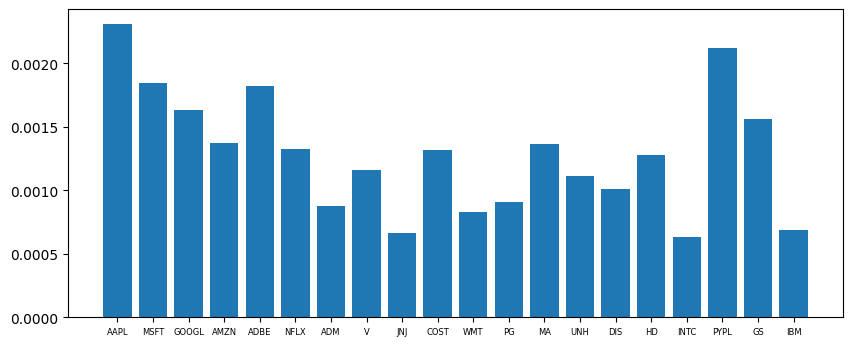

[[1.         0.78379046 0.67915592 0.6604699  0.70651173 0.49634134
  0.48778922 0.63718706 0.48536299 0.58812225 0.43762125 0.49100697
  0.62597919 0.50018844 0.42739668 0.60574887 0.58409712 0.65935318
  0.52513418 0.47899584]
 [0.78379046 1.         0.78564094 0.71412    0.83786003 0.54620378
  0.50841568 0.7370294  0.56250986 0.64724104 0.51986293 0.5806622
  0.71526769 0.58025331 0.49331703 0.68128812 0.64602625 0.74181833
  0.54420627 0.54640818]
 [0.67915592 0.78564094 1.         0.64363432 0.71602765 0.50522
  0.47472201 0.68466181 0.4781614  0.53050153 0.40293533 0.47770626
  0.66157294 0.53352982 0.49778396 0.58444014 0.55230008 0.63585912
  0.53545229 0.51275604]
 [0.6604699  0.71412    0.64363432 1.         0.70380618 0.61436374
  0.28728127 0.4430769  0.3316662  0.52925204 0.37774353 0.37146405
  0.45654999 0.35659167 0.30777134 0.42433058 0.46097831 0.59482233
  0.3208997  0.35373136]
 [0.70651173 0.83786003 0.71602765 0.70380618 1.         0.61164788
  0.4312582  0.65310

In [10]:
#Mean vector and covariance of the whole data of losses
mu_losses=np.mean(daily_losses,axis=0)
Sigma_losses=np.cov(daily_losses, rowvar=False)


#Correlation matrix of the whole data
Sigma_losses_corr=np.corrcoef(daily_losses, rowvar=False)



#Figure of the Mean vector of the return
plt.figure(figsize=(10,4))
plt.xticks(fontsize=6)
plt.bar(tickers,-mu_losses)
plt.show()


#Print the correlation matrix
print(Sigma_losses_corr)

In [11]:
#Creat functions

##PD_k(F_{\nu}) where F_{\nu} is the unit variance t-distribution with the tail parameter \nu
def PD_t(k,nu):    
    def integrand(s):
        return k*s**(k-1)*t.ppf(s, nu)   
    return quad(integrand, 0, 1)[0]        
 




##PD_k(w^T X) where w is the portfolio and X is data variable
def PD_SAA(k,w,data):    
    loss=w @ data.T
    rank_loss=np.sort(loss)
    n=len(data[:,0])
    prob = np.diff([(s / n) ** k for s in range(n + 1)])
    return rank_loss @ prob


##\zeta_k, \xi_k
def zeta(k):
    return k/np.sqrt(2*k-1)

def xi(k):
    return (np.sqrt(math.pi)*gamma(k+1))/(2*gamma(k+1/2))




##Robust optimization under WR and MA; Objetive function: w^T \mu + coef1*\sqrt(w^T \Sigma w) + coef2*\sqrt(w^T w); Constraint w^T \mu<=-r0/m 
def Robust_opt(mean,cov,target_mean,coef1,coef2):
    mu=mean
    Sigma=cov
    r0=target_mean
    d=len(mu)
    Sigma_sqrt = np.linalg.cholesky(Sigma)
#Portfolio 
    w=cp.Variable(d)
#Auxiliary parameter
    t=cp.Variable()
#    s=cp.Variable()
#Objective function and constraints
    objective=w @ mu+coef1*t+coef2*cp.norm(w, 2)
    constraints=[w @ mu<=-r0, cp.sum(w)==1, w>=0, cp.SOC(t, Sigma_sqrt @ w)]
#Solve the optimization problem
    prob=cp.Problem(cp.Minimize(objective),constraints)  
    prob.solve(solver=cp.MOSEK)
    result= {
        'opt_solution': w.value,
        'opt_value': prob.value,
    }
    return result


##SAA approach; Objetive function: PD_k(w^T X) where X is data variable; Constraint w^T \mu<=-r0/m 
def SAA_opt(k,data,target_mean):
    mu=np.mean(data,axis=0)
    r0=target_mean
    def objective(w):
        return PD_SAA(k,w,data)
    constraints = [
      {'type': 'ineq', 'fun': lambda w: -(w @ mu) - r0},   # w @ mu <= -r0
      {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},      # sum(w) == 1
      {'type': 'ineq', 'fun': lambda w: w}                 # w >= 0
    ]

    n=len(mu)
    x_0=np.full(n, 1/n)     #Initial portfolio
    
    result_initial=minimize(objective, x_0, method='SLSQP',constraints=constraints)
    result= {
        'opt_solution': result_initial.x,
        'opt_value': result_initial.fun,
    }
    return result



##Markowitz mean-variance approach; Objetive function: \sqrt(w^T \Sigma w); Constraint w^T \mu<=-r0/m 
def MV_opt(mean,cov,target_mean):
    mu=mean
    Sigma=cov
    r0=target_mean
    d=len(mu)
#Portfolio 
    w=cp.Variable(d)
#Objective function and constraints
    objective=cp.quad_form(w, Sigma)
    constraints=[w @ mu<=-r0, cp.sum(w)==1, w>=0]
#Solve the optimization problem
    prob=cp.Problem(cp.Minimize(objective),constraints)  
    prob.solve(solver=cp.MOSEK)
    result= {
        'opt_solution': w.value,
        'opt_value': prob.value,
    }
    return result




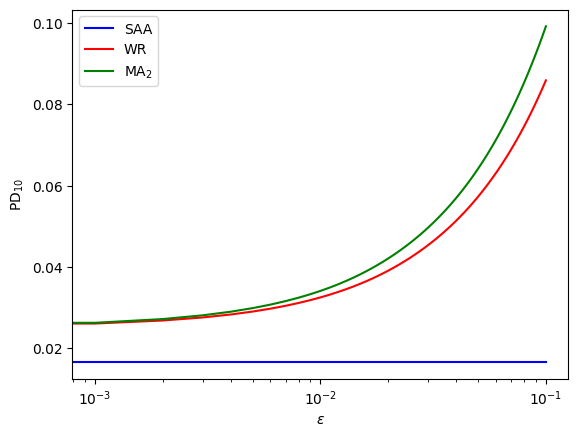

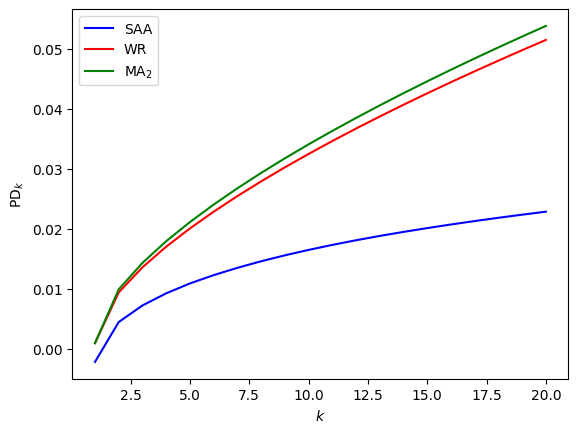

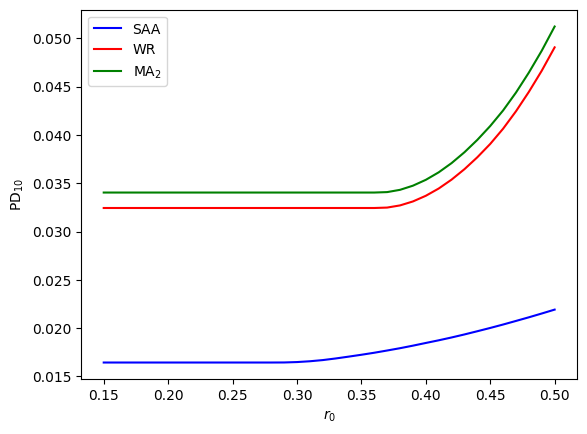

In [12]:
#The optimized robust values of PDk under Wasserstein uncertainty using the whole-period data (Figure 4)


##Radius \epsilon varies (r_0=0.2, k=10, m=250)
r_0=0.2
k=10
m=250
epsilon=np.linspace(0, 0.1, int(0.1 / 0.001) + 1)    #[0,0.001,0.002,...,0.1]
n=len(epsilon)
nu=1.5


###SAA approach
rho_epsilon_SAA=np.ones(n)*SAA_opt(k,daily_losses,r_0/m)['opt_value']   

###WR approach
rho_epsilon_WR=np.zeros(n)
coef1=PD_t(k,nu)


for i in range(n):
    coef2=zeta(k)*epsilon[i]
    rho_epsilon_WR[i]=Robust_opt(mu_losses,Sigma_losses,r_0/m,coef1,coef2)['opt_value']

###MA approach
rho_epsilon_MA2=np.zeros(n)
coef1=PD_t(k,nu)


for i in range(n):
    coef2=xi(k)*epsilon[i]
    rho_epsilon_MA2[i]=Robust_opt(mu_losses,Sigma_losses,r_0/m,coef1,coef2)['opt_value']

###Plot the figure
plt.plot(epsilon, rho_epsilon_SAA, label="SAA", color="blue")
plt.plot(epsilon, rho_epsilon_WR, label="WR", color="red")
plt.plot(epsilon, rho_epsilon_MA2, label="$\mathrm{MA}_2$", color="green")

plt.xlabel("$\epsilon$")
plt.ylabel("$\mathrm{PD}_{10}$")
plt.xscale('log')    
plt.legend()

plt.show()



##Power order k varies (epsilon=0.01, r_0=0.2, m=250)
epsilon=0.01
r_0=0.2
m=250
k=np.linspace(1, 20, 20)    #[1,2,...,20]
n=len(k)
nu=1.5


###SAA approach
rho_k_SAA=np.zeros(n)

for i in range(n):
    rho_k_SAA[i]=SAA_opt(k[i],daily_losses,r_0/m)['opt_value']   

###WR approach
rho_k_WR=np.zeros(n)

for i in range(n):
    coef1=PD_t(k[i],nu)
    coef2=zeta(k[i])*epsilon
    rho_k_WR[i]=Robust_opt(mu_losses,Sigma_losses,r_0/m,coef1,coef2)['opt_value']

###MA approach
rho_k_MA2=np.zeros(n)

for i in range(n):
    coef1=PD_t(k[i],nu)
    coef2=xi(k[i])*epsilon
    rho_k_MA2[i]=Robust_opt(mu_losses,Sigma_losses,r_0/m,coef1,coef2)['opt_value']

###Plot the figure
plt.plot(k, rho_k_SAA, label="SAA", color="blue")
plt.plot(k, rho_k_WR, label="WR", color="red")
plt.plot(k, rho_k_MA2, label="$\mathrm{MA}_2$", color="green")

plt.xlabel("$k$")
plt.ylabel("$\mathrm{PD}_{k}$")
plt.legend()

plt.show()





##Target wealth r_0 varies (epsilon=0.01, k=10, m=250)
epsilon=0.01
k=10
m=300
r_0=np.linspace(0.15, 0.5, int((0.5-0.15)/0.01)+1)    #[0.15,0.16,...,0.5]
n=len(r_0)
nu=1.5


###SAA approach
rho_r0_SAA=np.zeros(n)

for i in range(n):
    rho_r0_SAA[i]=SAA_opt(k,daily_losses,r_0[i]/m)['opt_value']   

###WR approach
rho_r0_WR=np.zeros(n)
coef1=PD_t(k,nu)
coef2=zeta(k)*epsilon

for i in range(n):
    rho_r0_WR[i]=Robust_opt(mu_losses,Sigma_losses,r_0[i]/m,coef1,coef2)['opt_value']

###MA approach
rho_r0_MA2=np.zeros(n)
coef1=PD_t(k,nu)
coef2=xi(k)*epsilon

for i in range(n):
    rho_r0_MA2[i]=Robust_opt(mu_losses,Sigma_losses,r_0[i]/m,coef1,coef2)['opt_value']

###Plot the figure
plt.plot(r_0, rho_r0_SAA, label="SAA", color="blue")
plt.plot(r_0, rho_r0_WR, label="WR", color="red")
plt.plot(r_0, rho_r0_MA2, label="$\mathrm{MA}_2$", color="green")

plt.xlabel("$r_0$")
plt.ylabel("$\mathrm{PD}_{10}$")
plt.legend()

plt.show()



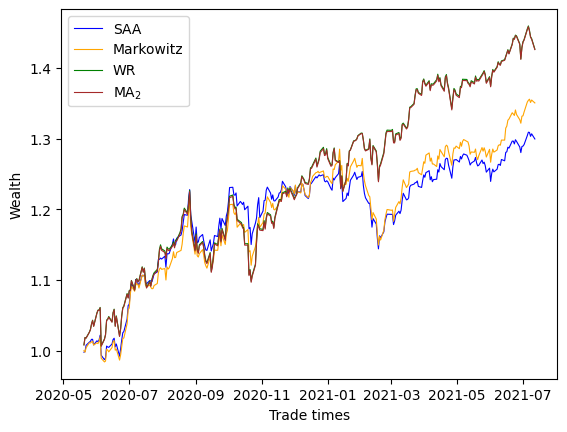

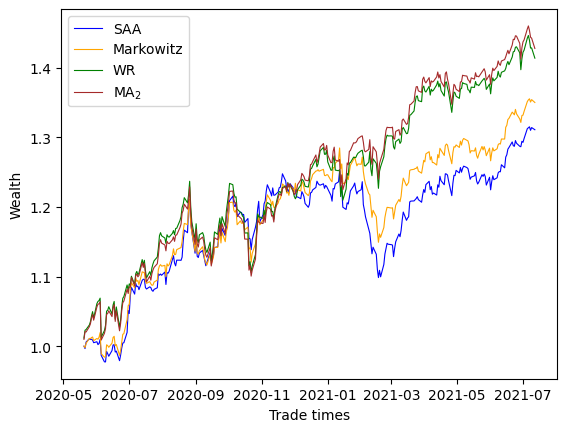

In [13]:
#Wealth evolution for different portfolio strategies from May 2020 to Aug 2021; epsilon=0.01, r_0=0.2 (Figure 5)
epsilon=0.01 
r_0=0.2
rolling_num=350
n=len(daily_losses[:,0])-rolling_num
m=250

##The case k=2
k=2

###SAA approach
rolling_SAA_portfolio_2=np.empty(n, dtype=object)

for i in range(n):
    rolling_SAA_portfolio_2[i]=SAA_opt(k,daily_losses[i:(i+rolling_num),:],r_0/m)['opt_solution']   

###Markowitz mean-variance approach
rolling_MV_portfolio_2=np.empty(n, dtype=object)

for i in range(n):
    rolling_MV_portfolio_2[i]=MV_opt(np.mean(daily_losses[i:(i+rolling_num),:],axis=0),np.cov(daily_losses[i:(i+rolling_num),:],rowvar=False),r_0/m)['opt_solution']   

###WR approach
rolling_WR_portfolio_2=np.empty(n, dtype=object)
coef1=PD_t(k,nu)
coef2=zeta(k)*epsilon

for i in range(n):
    rolling_WR_portfolio_2[i]=Robust_opt(np.mean(daily_losses[i:(i+rolling_num),:],axis=0),np.cov(daily_losses[i:(i+rolling_num),:],rowvar=False),r_0/m,coef1,coef2)['opt_solution']

###MA approach
rolling_MA2_portfolio_2=np.empty(n, dtype=object)
coef1=PD_t(k,nu)
coef2=xi(k)*epsilon

for i in range(n):
    rolling_MA2_portfolio_2[i]=Robust_opt(np.mean(daily_losses[i:(i+rolling_num),:],axis=0),np.cov(daily_losses[i:(i+rolling_num),:],rowvar=False),r_0/m,coef1,coef2)['opt_solution']


###Wealth evolution
initial_wealth = 1
return_rate=daily_returns[rolling_num:,:]

####SAA approach
return_rate_SAA_2=np.zeros(n)
for i in range(n):
    return_rate_SAA_2[i]=rolling_SAA_portfolio_2[i] @ return_rate[i,:]   

wealth_SAA_2=initial_wealth * np.cumprod(1 + return_rate_SAA_2)    

####Markowitz mean-variance approach
return_rate_MV_2=np.zeros(n)
for i in range(n):
    return_rate_MV_2[i]=rolling_MV_portfolio_2[i] @ return_rate[i,:]   

wealth_MV_2=initial_wealth * np.cumprod(1 + return_rate_MV_2)   

####WR approach
return_rate_WR_2=np.zeros(n)
for i in range(n):
    return_rate_WR_2[i]=rolling_WR_portfolio_2[i] @ return_rate[i,:]   

wealth_WR_2=initial_wealth * np.cumprod(1 + return_rate_WR_2)    

####MA2 approach
return_rate_MA2_2=np.zeros(n)
for i in range(n):
    return_rate_MA2_2[i]=rolling_MA2_portfolio_2[i] @ return_rate[i,:]   

wealth_MA2_2=initial_wealth * np.cumprod(1 + return_rate_MA2_2)    


###Plot the figure
trade_times = pd.date_range(start="2020-05-20", periods=n, freq="B")  

plt.plot(trade_times, wealth_SAA_2, label="SAA", color="blue", linewidth=0.8)
plt.plot(trade_times, wealth_MV_2, label="Markowitz", color="orange", linewidth=0.8)
plt.plot(trade_times, wealth_WR_2, label="WR", color="green", linewidth=0.8)
plt.plot(trade_times, wealth_MA2_2, label="$\mathrm{MA}_2$", color="brown", linewidth=0.8)

plt.xlabel("Trade times")
plt.ylabel("Wealth")
plt.legend()

# 显示图形
plt.show()




##The case k=20
k=20

###SAA approach
rolling_SAA_portfolio_20=np.empty(n, dtype=object)

for i in range(n):
    rolling_SAA_portfolio_20[i]=SAA_opt(k,daily_losses[i:(i+rolling_num),:],r_0/m)['opt_solution']   

###Markowitz mean-variance approach
rolling_MV_portfolio_20=np.empty(n, dtype=object)

for i in range(n):
    rolling_MV_portfolio_20[i]=MV_opt(np.mean(daily_losses[i:(i+rolling_num),:],axis=0),np.cov(daily_losses[i:(i+rolling_num),:],rowvar=False),r_0/m)['opt_solution']   

###WR approach
rolling_WR_portfolio_20=np.empty(n, dtype=object)
coef1=PD_t(k,nu)
coef2=zeta(k)*0

for i in range(n):
    rolling_WR_portfolio_20[i]=Robust_opt(np.mean(daily_losses[i:(i+rolling_num),:],axis=0),np.cov(daily_losses[i:(i+rolling_num),:],rowvar=False),r_0/m,coef1,coef2)['opt_solution']

###MA approach
rolling_MA2_portfolio_20=np.empty(n, dtype=object)
coef1=PD_t(k,nu)
coef2=xi(k)*epsilon

for i in range(n):
    rolling_MA2_portfolio_20[i]=Robust_opt(np.mean(daily_losses[i:(i+rolling_num),:],axis=0),np.cov(daily_losses[i:(i+rolling_num),:],rowvar=False),r_0/m,coef1,coef2)['opt_solution']


###Wealth evolution
initial_wealth = 1
return_rate=daily_returns[rolling_num:,:]

####SAA approach
return_rate_SAA_20=np.zeros(n)
for i in range(n):
    return_rate_SAA_20[i]=rolling_SAA_portfolio_20[i] @ return_rate[i,:]   

wealth_SAA_20=initial_wealth * np.cumprod(1 + return_rate_SAA_20)    

####Markowitz mean-variance approach
return_rate_MV_20=np.zeros(n)
for i in range(n):
    return_rate_MV_20[i]=rolling_MV_portfolio_20[i] @ return_rate[i,:]   

wealth_MV_20=initial_wealth * np.cumprod(1 + return_rate_MV_20)   

####WR approach
return_rate_WR_20=np.zeros(n)
for i in range(n):
    return_rate_WR_20[i]=rolling_WR_portfolio_20[i] @ return_rate[i,:]   

wealth_WR_20=initial_wealth * np.cumprod(1 + return_rate_WR_20)    

####MA2 approach
return_rate_MA2_20=np.zeros(n)
for i in range(n):
    return_rate_MA2_20[i]=rolling_MA2_portfolio_20[i] @ return_rate[i,:]   

wealth_MA2_20=initial_wealth * np.cumprod(1 + return_rate_MA2_20)    


###Plot the figure
trade_times = pd.date_range(start="2020-05-20", periods=n, freq="B")  

plt.plot(trade_times, wealth_SAA_20, label="SAA", color="blue", linewidth=0.8)
plt.plot(trade_times, wealth_MV_20, label="Markowitz", color="orange", linewidth=0.8)
plt.plot(trade_times, wealth_WR_20, label="WR", color="green", linewidth=0.8)
plt.plot(trade_times, wealth_MA2_20, label="$\mathrm{MA}_2$", color="brown", linewidth=0.8)

plt.xlabel("Trade times")
plt.ylabel("Wealth")
plt.legend()

# 显示图形
plt.show()



In [15]:
#Annualized return (AR), annualized volatility (AV) and Sharpe ratio (SR); r_0=0.2, risk free rate=0.165% 
risk_free_rate = 0.00165

##AR
###k=2
average_daily_return_SAA_2 = np.mean(return_rate_SAA_2)           
annualized_return_SAA_2 = (1 + average_daily_return_SAA_2) **m - 1    #SAA

average_daily_return_MV_2 = np.mean(return_rate_MV_2)           
annualized_return_MV_2 = (1 + average_daily_return_MV_2) **m - 1      #Markowitz mean-variance

average_daily_return_WR_2 = np.mean(return_rate_WR_2)           
annualized_return_WR_2 = (1 + average_daily_return_WR_2) **m - 1      #WR

average_daily_return_MA2_2 = np.mean(return_rate_MA2_2)           
annualized_return_MA2_2 = (1 + average_daily_return_MA2_2) **m - 1    #MA


###k=20
average_daily_return_SAA_20 = np.mean(return_rate_SAA_20)           
annualized_return_SAA_20 = (1 + average_daily_return_SAA_20) **m - 1    #SAA

average_daily_return_MV_20 = np.mean(return_rate_MV_20)           
annualized_return_MV_20 = (1 + average_daily_return_MV_20) **m - 1      #Markowitz mean-variance

average_daily_return_WR_20 = np.mean(return_rate_WR_20)           
annualized_return_WR_20 = (1 + average_daily_return_WR_20) **m - 1      #WR

average_daily_return_MA2_20 = np.mean(return_rate_MA2_20)           
annualized_return_MA2_20 = (1 + average_daily_return_MA2_20) **m - 1    #MA



##AV
###k=2
daily_volatility_SAA_2 = np.std(return_rate_SAA_2)
annualized_volatility_SAA_2 = daily_volatility_SAA_2 * np.sqrt(m)    #SAA

daily_volatility_MV_2 = np.std(return_rate_MV_2)
annualized_volatility_MV_2 = daily_volatility_MV_2 * np.sqrt(m)      #Markowitz mean-variance

daily_volatility_WR_2 = np.std(return_rate_WR_2)
annualized_volatility_WR_2 = daily_volatility_WR_2 * np.sqrt(m)      #WR

daily_volatility_MA2_2 = np.std(return_rate_MA2_2)
annualized_volatility_MA2_2 = daily_volatility_MA2_2 * np.sqrt(m)    #MA


###k=20
daily_volatility_SAA_20 = np.std(return_rate_SAA_20)
annualized_volatility_SAA_20 = daily_volatility_SAA_20 * np.sqrt(m)    #SAA

daily_volatility_MV_20 = np.std(return_rate_MV_20)
annualized_volatility_MV_20 = daily_volatility_MV_20 * np.sqrt(m)      #Markowitz mean-variance

daily_volatility_WR_20 = np.std(return_rate_WR_20)
annualized_volatility_WR_20 = daily_volatility_WR_20 * np.sqrt(m)      #WR

daily_volatility_MA2_20 = np.std(return_rate_MA2_20)
annualized_volatility_MA2_20 = daily_volatility_MA2_20 * np.sqrt(m)    #MA



##SR
###k=2
sharpe_ratio_SAA_2 = (annualized_return_SAA_2 - risk_free_rate) / annualized_volatility_SAA_2
sharpe_ratio_MV_2 = (annualized_return_MV_2 - risk_free_rate) / annualized_volatility_MV_2
sharpe_ratio_WR_2 = (annualized_return_WR_2 - risk_free_rate) / annualized_volatility_WR_2
sharpe_ratio_MA2_2 = (annualized_return_MA2_2 - risk_free_rate) / annualized_volatility_MA2_2


###k=20
sharpe_ratio_SAA_20 = (annualized_return_SAA_20 - risk_free_rate) / annualized_volatility_SAA_20
sharpe_ratio_MV_20 = (annualized_return_MV_20 - risk_free_rate) / annualized_volatility_MV_20
sharpe_ratio_WR_20 = (annualized_return_WR_20 - risk_free_rate) / annualized_volatility_WR_20
sharpe_ratio_MA2_20 = (annualized_return_MA2_20 - risk_free_rate) / annualized_volatility_MA2_20

In [17]:
#Nominal transaction cost (epsilon=0.01, T=229)
T=299
epsilon=0.01

##r_0=0.2, k=2 or 20
###k=2
cost_SAA_2 = sum(np.linalg.norm(rolling_SAA_portfolio_2[t+1] - rolling_SAA_portfolio_2[t], ord=1) for t in range(T-1)) / T
cost_MV_2 = sum(np.linalg.norm(rolling_MV_portfolio_2[t+1] - rolling_MV_portfolio_2[t], ord=1) for t in range(T-1)) / T
cost_WR_2 = sum(np.linalg.norm(rolling_WR_portfolio_2[t+1] - rolling_WR_portfolio_2[t], ord=1) for t in range(T-1)) / T
cost_MA2_2 = sum(np.linalg.norm(rolling_MA2_portfolio_2[t+1] - rolling_MA2_portfolio_2[t], ord=1) for t in range(T-1)) / T

###k=20
cost_SAA_20 = sum(np.linalg.norm(rolling_SAA_portfolio_20[t+1] - rolling_SAA_portfolio_20[t], ord=1) for t in range(T-1)) / T
cost_MV_20 = sum(np.linalg.norm(rolling_MV_portfolio_20[t+1] - rolling_MV_portfolio_20[t], ord=1) for t in range(T-1)) / T
cost_WR_20 = sum(np.linalg.norm(rolling_WR_portfolio_20[t+1] - rolling_WR_portfolio_20[t], ord=2) for t in range(T-1)) / T
cost_MA2_20 = sum(np.linalg.norm(rolling_MA2_portfolio_20[t+1] - rolling_MA2_portfolio_20[t], ord=2) for t in range(T-1)) / T






##r_0=0.1, k=2 or 20
r_0=0.1
###k=2
k=2
###SAA approach
rolling_SAA1_portfolio_2=np.empty(n, dtype=object)

for i in range(n):
    rolling_SAA1_portfolio_2[i]=SAA_opt(k,daily_losses[i:(i+rolling_num),:],r_0/m)['opt_solution']   
cost_SAA1_2 = sum(np.linalg.norm(rolling_SAA1_portfolio_2[t+1] - rolling_SAA1_portfolio_2[t], ord=1) for t in range(T-1)) / T

###Markowitz mean-variance approach
rolling_MV1_portfolio_2=np.empty(n, dtype=object)

for i in range(n):
    rolling_MV1_portfolio_2[i]=MV_opt(np.mean(daily_losses[i:(i+rolling_num),:],axis=0),np.cov(daily_losses[i:(i+rolling_num),:],rowvar=False),r_0/m)['opt_solution']   
cost_MV1_2 = sum(np.linalg.norm(rolling_MV1_portfolio_2[t+1] - rolling_MV1_portfolio_2[t], ord=1) for t in range(T-1)) / T

###WR approach
rolling_WR1_portfolio_2=np.empty(n, dtype=object)
coef1=PD_t(k,nu)
coef2=zeta(k)*epsilon

for i in range(n):
    rolling_WR1_portfolio_2[i]=Robust_opt(np.mean(daily_losses[i:(i+rolling_num),:],axis=0),np.cov(daily_losses[i:(i+rolling_num),:],rowvar=False),r_0/m,coef1,coef2)['opt_solution']
cost_WR1_2 = sum(np.linalg.norm(rolling_WR1_portfolio_2[t+1] - rolling_WR1_portfolio_2[t], ord=1) for t in range(T-1)) / T

###MA approach
rolling_MA21_portfolio_2=np.empty(n, dtype=object)
coef1=PD_t(k,nu)
coef2=xi(k)*epsilon

for i in range(n):
    rolling_MA21_portfolio_2[i]=Robust_opt(np.mean(daily_losses[i:(i+rolling_num),:],axis=0),np.cov(daily_losses[i:(i+rolling_num),:],rowvar=False),r_0/m,coef1,coef2)['opt_solution']
cost_MA21_2 = sum(np.linalg.norm(rolling_MA21_portfolio_2[t+1] - rolling_MA21_portfolio_2[t], ord=1) for t in range(T-1)) / T

###k=20
k=20
###SAA approach
rolling_SAA1_portfolio_20=np.empty(n, dtype=object)

for i in range(n):
    rolling_SAA1_portfolio_20[i]=SAA_opt(k,daily_losses[i:(i+rolling_num),:],r_0/m)['opt_solution']   
cost_SAA1_20 = sum(np.linalg.norm(rolling_SAA1_portfolio_20[t+1] - rolling_SAA1_portfolio_20[t], ord=1) for t in range(T-1)) / T

###Markowitz mean-variance approach
rolling_MV1_portfolio_20=np.empty(n, dtype=object)

for i in range(n):
    rolling_MV1_portfolio_20[i]=MV_opt(np.mean(daily_losses[i:(i+rolling_num),:],axis=0),np.cov(daily_losses[i:(i+rolling_num),:],rowvar=False),r_0/m)['opt_solution']   
cost_MV1_20 = sum(np.linalg.norm(rolling_MV1_portfolio_20[t+1] - rolling_MV1_portfolio_20[t], ord=1) for t in range(T-1)) / T

###WR approach
rolling_WR1_portfolio_20=np.empty(n, dtype=object)
coef1=PD_t(k,nu)
coef2=zeta(k)*epsilon

for i in range(n):
    rolling_WR1_portfolio_20[i]=Robust_opt(np.mean(daily_losses[i:(i+rolling_num),:],axis=0),np.cov(daily_losses[i:(i+rolling_num),:],rowvar=False),r_0/m,coef1,coef2)['opt_solution']
cost_WR1_20 = sum(np.linalg.norm(rolling_WR1_portfolio_20[t+1] - rolling_WR1_portfolio_20[t], ord=2) for t in range(T-1)) / T

###MA approach
rolling_MA21_portfolio_20=np.empty(n, dtype=object)
coef1=PD_t(k,nu)
coef2=xi(k)*epsilon

for i in range(n):
    rolling_MA21_portfolio_20[i]=Robust_opt(np.mean(daily_losses[i:(i+rolling_num),:],axis=0),np.cov(daily_losses[i:(i+rolling_num),:],rowvar=False),r_0/m,coef1,coef2)['opt_solution']
cost_MA21_20 = sum(np.linalg.norm(rolling_MA21_portfolio_20[t+1] - rolling_MA21_portfolio_20[t], ord=2) for t in range(T-1)) / T








##r_0=0.3, k=2 or 20
r_0=0.3
###k=2
k=2
###SAA approach
rolling_SAA3_portfolio_2=np.empty(n, dtype=object)

for i in range(n):
    rolling_SAA3_portfolio_2[i]=SAA_opt(k,daily_losses[i:(i+rolling_num),:],r_0/m)['opt_solution']   
cost_SAA3_2 = sum(np.linalg.norm(rolling_SAA3_portfolio_2[t+1] - rolling_SAA3_portfolio_2[t], ord=1) for t in range(T-1)) / T

###Markowitz mean-variance approach
rolling_MV3_portfolio_2=np.empty(n, dtype=object)

for i in range(n):
    rolling_MV3_portfolio_2[i]=MV_opt(np.mean(daily_losses[i:(i+rolling_num),:],axis=0),np.cov(daily_losses[i:(i+rolling_num),:],rowvar=False),r_0/m)['opt_solution']   
cost_MV3_2 = sum(np.linalg.norm(rolling_MV3_portfolio_2[t+1] - rolling_MV3_portfolio_2[t], ord=1) for t in range(T-1)) / T

###WR approach
rolling_WR3_portfolio_2=np.empty(n, dtype=object)
coef1=PD_t(k,nu)
coef2=zeta(k)*epsilon

for i in range(n):
    rolling_WR3_portfolio_2[i]=Robust_opt(np.mean(daily_losses[i:(i+rolling_num),:],axis=0),np.cov(daily_losses[i:(i+rolling_num),:],rowvar=False),r_0/m,coef1,coef2)['opt_solution']
cost_WR3_2 = sum(np.linalg.norm(rolling_WR3_portfolio_2[t+1] - rolling_WR3_portfolio_2[t], ord=1) for t in range(T-1)) / T

###MA approach
rolling_MA23_portfolio_2=np.empty(n, dtype=object)
coef1=PD_t(k,nu)
coef2=xi(k)*epsilon

for i in range(n):
    rolling_MA23_portfolio_2[i]=Robust_opt(np.mean(daily_losses[i:(i+rolling_num),:],axis=0),np.cov(daily_losses[i:(i+rolling_num),:],rowvar=False),r_0/m,coef1,coef2)['opt_solution']
cost_MA23_2 = sum(np.linalg.norm(rolling_MA23_portfolio_2[t+1] - rolling_MA23_portfolio_2[t], ord=1) for t in range(T-1)) / T

###k=20
k=20
###SAA approach
rolling_SAA3_portfolio_20=np.empty(n, dtype=object)

for i in range(n):
    rolling_SAA3_portfolio_20[i]=SAA_opt(k,daily_losses[i:(i+rolling_num),:],r_0/m)['opt_solution']   
cost_SAA3_20 = sum(np.linalg.norm(rolling_SAA3_portfolio_20[t+1] - rolling_SAA3_portfolio_20[t], ord=1) for t in range(T-1)) / T

###Markowitz mean-variance approach
rolling_MV3_portfolio_20=np.empty(n, dtype=object)

for i in range(n):
    rolling_MV3_portfolio_20[i]=MV_opt(np.mean(daily_losses[i:(i+rolling_num),:],axis=0),np.cov(daily_losses[i:(i+rolling_num),:],rowvar=False),r_0/m)['opt_solution']   
cost_MV3_20 = sum(np.linalg.norm(rolling_MV3_portfolio_20[t+1] - rolling_MV3_portfolio_20[t], ord=1) for t in range(T-1)) / T

###WR approach
rolling_WR3_portfolio_20=np.empty(n, dtype=object)
coef1=PD_t(k,nu)
coef2=zeta(k)*epsilon

for i in range(n):
    rolling_WR3_portfolio_20[i]=Robust_opt(np.mean(daily_losses[i:(i+rolling_num),:],axis=0),np.cov(daily_losses[i:(i+rolling_num),:],rowvar=False),r_0/m,coef1,coef2)['opt_solution']
cost_WR3_20 = sum(np.linalg.norm(rolling_WR3_portfolio_20[t+1] - rolling_WR3_portfolio_20[t], ord=1) for t in range(T-1)) / T

###MA approach
rolling_MA23_portfolio_20=np.empty(n, dtype=object)
coef1=PD_t(k,nu)
coef2=xi(k)*epsilon

for i in range(n):
    rolling_MA23_portfolio_20[i]=Robust_opt(np.mean(daily_losses[i:(i+rolling_num),:],axis=0),np.cov(daily_losses[i:(i+rolling_num),:],rowvar=False),r_0/m,coef1,coef2)['opt_solution']
cost_MA23_20 = sum(np.linalg.norm(rolling_MA23_portfolio_20[t+1] - rolling_MA23_portfolio_20[t], ord=1) for t in range(T-1)) / T

